In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import random
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense ,Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Load dataset

In [ ]:
da = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LabRNN/bitcoin/BTC_USD_2013-10-01_2021-03-30.csv')
da.head()
dataset = da.copy()
dataset_labels = dataset.pop('Closing Price (USD)')
dataset = np.array(dataset_labels)
#dataset

Scaler dataset

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
dataset = dataset.reshape(-1, 1)
dataset_scaled = sc.fit_transform(dataset)
#dataset_scaled

Tạo input

In [ ]:
X = []
Y = []
n_future = 1 # next 1 days forecast
n_past = 30 # Past 30 days 
for i in range(0,len(dataset_scaled)-n_past-n_future+1):
    X.append(dataset_scaled[i : i + n_past , 0])     
    Y.append(dataset_scaled[i + n_past : i + n_past + n_future , 0 ])
X , Y = np.array(X), np.array(Y)
X = np.reshape(X, (X.shape[0] , X.shape[1], 1) )

In [ ]:
len(X)

2708

Tạp tập train và tập test.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.01)

In [ ]:
len(X_train)

2680

In [ ]:
len(X_test)

28

Lưu X_train, X_test, Y_train và Y_test

In [ ]:
#train
pickle_out = open("/content/drive/MyDrive/Colab Notebooks/LabRNN/bitcoin/X_train.pickle", "wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/Colab Notebooks/LabRNN/bitcoin/Y_train.pickle", "wb")
pickle.dump(Y_train, pickle_out)
pickle_out.close()

#test
pickle_out = open("/content/drive/MyDrive/Colab Notebooks/LabRNN/bitcoin/X_test.pickle", "wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/Colab Notebooks/LabRNN/bitcoin/Y_test.pickle", "wb")
pickle.dump(Y_test, pickle_out)
pickle_out.close()

Đọc các X Y train test mà ta đã lưu

In [ ]:
#train
pickle_in = open("/content/drive/MyDrive/Colab Notebooks/LabRNN/bitcoin/X_train.pickle", "rb")
X_train = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("/content/drive/MyDrive/Colab Notebooks/LabRNN/bitcoin/Y_train.pickle", "rb")
Y_train = pickle.load(pickle_in)
pickle_in.close()

#test
pickle_in = open("/content/drive/MyDrive/Colab Notebooks/LabRNN/bitcoin/X_test.pickle", "rb")
X_test = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("/content/drive/MyDrive/Colab Notebooks/LabRNN/bitcoin/Y_test.pickle", "rb")
Y_test = pickle.load(pickle_in)
pickle_in.close()

Xây dựng model

In [ ]:
# load lại model cũ đã lưu
#regressor = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/LabRNN/bitcoin/my_model.h5')
#regressor.summary()

In [ ]:
regressor = Sequential()
regressor.add(Bidirectional(LSTM(units=30, return_sequences=True, input_shape = (X_train.shape[1],1) ) ))

regressor.add(LSTM(units= 30 , return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units= 30 , return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units= 30))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = n_future, activation='linear'))

regressor.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc'])

history = regressor.fit(X_train, Y_train, epochs=100, batch_size=32 )

regressor.summary()

Epoch 1/100
84/84 [==============================] - 13s 51ms/step - loss: 0.0089 - acc: 0.0000e+00
Epoch 2/100
84/84 [==============================] - 4s 52ms/step - loss: 0.0014 - acc: 0.0010
Epoch 3/100
84/84 [==============================] - 4s 53ms/step - loss: 0.0015 - acc: 4.5956e-04
Epoch 4/100
84/84 [==============================] - 4s 53ms/step - loss: 0.0012 - acc: 3.4454e-04
Epoch 5/100
84/84 [==============================] - 5s 54ms/step - loss: 0.0010 - acc: 7.3753e-04
Epoch 6/100
84/84 [==============================] - 5s 54ms/step - loss: 8.5952e-04 - acc: 5.5677e-05
Epoch 7/100
84/84 [==============================] - 4s 53ms/step - loss: 0.0011 - acc: 2.8397e-04
Epoch 8/100
84/84 [==============================] - 5s 54ms/step - loss: 7.4822e-04 - acc: 4.7487e-04
Epoch 9/100
84/84 [==============================] - 5s 54ms/step - loss: 8.2686e-04 - acc: 2.7478e-04
Epoch 10/100
84/84 [==============================] - 4s 54ms/step - loss: 6.3602e-04 - acc: 4.0396e

Lưu lại model

In [ ]:
!mkdir -p saved_model
regressor.save('/content/drive/MyDrive/Colab Notebooks/LabRNN/bitcoin/my_model.h5')

Đánh giá mô hình

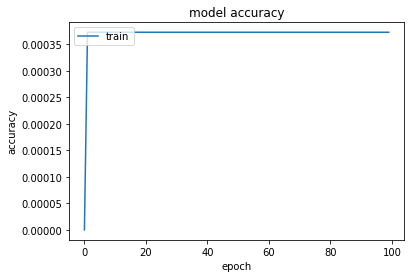

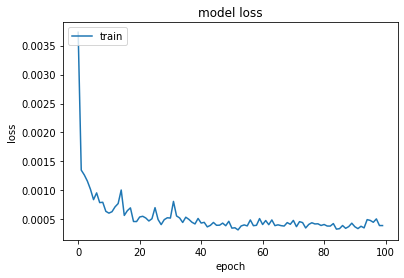

In [ ]:
# list all data in history
#print(history.history.keys())
#print(model.metrics_names)
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Đánh giá bằng tập test. 
Trực quan kết quả

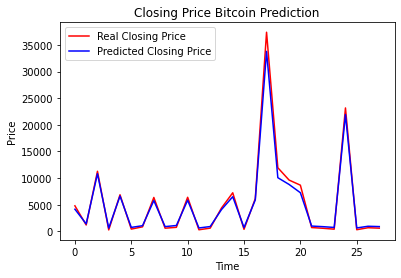

[[ 1189.55      ]
 [11278.2812549 ]
 [  261.71749   ]
 [ 6866.39818901]
 [  415.04      ]
 [  842.63875   ]
 [ 6360.14127192]
 [  585.39625   ]
 [  748.43559   ]
 [ 6392.17933738]
 [  289.7149    ]
 [  595.0175    ]
 [ 4370.16875   ]
 [ 7236.98620461]]
[[ 1402.2471 ]
 [10813.417  ]
 [  600.9827 ]
 [ 6623.893  ]
 [  734.50006]
 [ 1055.2456 ]
 [ 5775.9604 ]
 [  882.16064]
 [ 1092.6885 ]
 [ 5840.8765 ]
 [  627.96375]
 [  894.05554]
 [ 4076.1677 ]
 [ 6496.0493 ]]


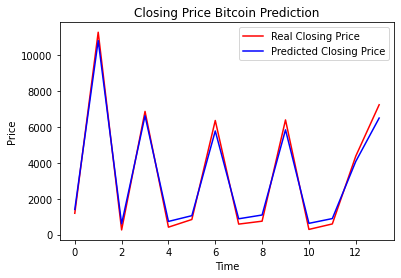

In [ ]:
predict = regressor.predict(X_test)

plt.plot(sc.inverse_transform(Y_test), color = 'red', label = 'Real Closing Price')
plt.plot(sc.inverse_transform(predict), color = 'blue', label = 'Predicted Closing Price')
plt.title('Closing Price Bitcoin Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.plot(sc.inverse_transform(Y_test[1:15]), color = 'red', label = 'Real Closing Price')
plt.plot(sc.inverse_transform(predict[1:15]), color = 'blue', label = 'Predicted Closing Price')
plt.title('Closing Price Bitcoin Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
print(sc.inverse_transform(Y_test[1:15]))
print(sc.inverse_transform(predict[1:15]))
plt.show()